In [1]:
#Load Modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import io
import requests

In [2]:
def OrganizeDf(df, KeyList):
    #This function organizes the Dataframe, so that the dates won't be column names, 
    #and each row will be a country caontaining a vector of cases ecery day
    v = df[KeyList[4:]].values
    df['cases'] = v.tolist()
    df = df.drop(KeyList[4:],axis = 1)
    df = df.drop(['Lat','Long'], axis = 1)
    return df

In [3]:
def CreatePlots(df,key,tit, isLog=True, isReturn=False):
    #Create ploys of a specified key, a logarithmic plot is possible
    v = df[key].values[0]
    if isLog:
        fig,axes = plt.subplots(2,1)
        axes[1].plot(v,marker='.')
        axes[1].set_title(tit+'-lograithmic')
        axes[1].set_yscale('log')
        axes[0].plot(v, marker='.')
        axes[0].set_title(tit+'-linear')
    else:
        axes,fig = plt.subplots(1,1)
        plt.plot(v, marker='.')
        plt.title(tit+'-linear')
    if isReturn:
        return axes
    #df.plot(y=key, marker = '.', ax=axes[0], title=tit+'-linear')
    #df.plot(y=key, marker = '.', ax=axes[1], title=tit+'-lograithmic', logy=True)

In [4]:
def AddMarksToPlot(axes,x,y,tit):
    #add markers at specified points
    if isinstance(axes,np.ndarray):
        for ax in axes:
            ax.scatter(x,y,color='r',zorder=0)
            for xi,yi in zip(x,y):
                ax.annotate(tit,(xi,yi))
    else:
        axes.scatter(x,y,marker='.',color='r',zorder=0)
        for xi,yi in zip(x,y):
                ax.annotate(tit,(xi,yi))

In [5]:
def deriveatives(df, tit, isPlot = True, key='cases',prefix=''):
    #Calculate first and second derivative and insert them into the dataframe with a specified prefix
    #v = np.array(df['cases'].values)
    v = np.array(df[key].values.tolist())
    d1 = (v[:,2:] - v[:,0:-2])/2
    d2 = (v[:,2:] - 2*v[:,1:-1] + v[:,0:-2])
    d1str = prefix+'first_derivative'
    d2str = prefix+'second_derivative'
    df[d1str] = d1.tolist()
    df[d2str] = d2.tolist()
    if isPlot:
        CreatePlots(df[df['Country/Region']=='worldwide'], d1str, tit+'1st derivative',isLog=False)
        CreatePlots(df[df['Country/Region']=='worldwide'], d2str, tit+'2nd derivative',isLog=False)
    return df

In [6]:
def manager(df,tit,KeyList,isOrganize = True, isSum=True, isPlot=True):
    #Manages the organisation and reading of the data recieved from the repository
    if isOrganize:
        df = OrganizeDf(df, KeyList)
    if isSum:
        tot = pd.DataFrame(df.cases.tolist()).sum(0)
        df.loc[-1] = ['worldwide','worldwide',tot.values]
    if isPlot:
        CreatePlots(df[df['Country/Region']=='worldwide'], 'cases', tit)
    df = deriveatives(df, tit, isPlot)
    return df

In [7]:
def AddExtremaToPlot(df,ax,key,d1Key,tol,MaxTit='maximum',MinTit='minimum'):
    indMax,indMin = FindExtrema(df,d1Key,tol)
    v = np.squeeze(np.array(df[key].values.tolist()))
    s = max(v.shape) - max(indMax.shape)
    temp = np.zeros(round(s/2),dtype=bool)
    indMax = np.concatenate((temp,indMax,temp))#Pad the indices with False from both sides
    #indMax = np.concatenate(([False],indMax,[False]))
    AddMarksToPlot(ax,np.argwhere(indMax),v[indMax],MaxTit)
    #indMin = np.concatenate(([False],indMin,[False]))
    indMin = np.concatenate((temp,indMin,temp))
    AddMarksToPlot(ax,np.argwhere(indMin),v[indMin],MinTit)

In [8]:
def rolling_window(a, window):
    #rolling window to smooth the data
    a = np.array(a)
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [16]:
def FindExtrema(df,d1key,tol,lim=5):
    #find zeros of given derivative, classify into maxima and minima, and return indinces
    d1val = np.array(df[d1key].values.tolist())
    indEx = abs(d1val) <= tol
    zero_crossingsMin = np.squeeze(np.array(np.where(np.diff(np.sign(d1val))>0)))
    zero_crossingsMax = np.squeeze(np.array(np.where(np.diff(np.sign(d1val))<0)))
    d2 = np.insert(np.squeeze(np.diff(d1val)),0,0)
    indMin = np.zeros(d1val.shape[1],dtype=bool)
    indMax = np.zeros(d1val.shape[1],dtype=bool)
    indMax[zero_crossingsMax] = True
    indMin[zero_crossingsMin] = True
    indMax = np.logical_and(indMax,abs(d2)>tol) 
    indMin = np.logical_and(indMin,abs(d2)>tol) 
    indMin[0:lim] = False#to avoid edge effects from initial noisy data
    indMax[0:lim] = False
    return indMax,indMin

In [23]:
def ShowData(df_current,key,d1key,d2key,tol1,tol2,isPlot1d=False,isPlot2d=False,tit=''):
    #plot data, add markers, and plot derivatives if desired
    #in order to not display extremum markers, set tol1 or tol2 to infinity
    if tit=='':
        tit = key
    ax = CreatePlots(df_current, key, tit,isReturn=True)
    AddExtremaToPlot(df_current,ax,key,d1key,tol1)#plot 1st derivative
    AddExtremaToPlot(df_current,ax,key,d2key,tol2,MaxTit='inflection',MinTit='inflection')#plot 2nd derivative
    if isPlot1d:
        CreatePlots(df_current, d1key, tit,isReturn=False)
    if isPlot2d:
        CreatePlots(df_current, d2key, tit,isReturn=False)

In [24]:
#get the data and create data frames
url_confirm = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_dead ='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_recover='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
urls = [url_confirm,url_dead,url_recover]
NewKeys = ['confirmed','dead','recovered']#names of keys
PlotTitle = ['confirmed','dead','recovered']#titles of plots corresponding to the data

for i,u in enumerate(urls):
    temp_df = pd.read_csv(u)
    KeyList = temp_df.keys()
    temp_df = manager(temp_df, PlotTitle[i], KeyList, isOrganize = True, isSum=True, isPlot=False)
    if i==0:
        d1 = datetime.strptime(KeyList[4], "%m/%d/%y")
        d2 = datetime.strptime(KeyList[-1], "%m/%d/%y")
        NDays = abs((d2 - d1).days)
        dateVec = KeyList[4:]
        df = temp_df
    else:
        df = df.join(temp_df[['cases','first_derivative','second_derivative']],how='outer')
    df = df.rename(columns={"cases":NewKeys[i]+'_cases'})
    df = df.rename(columns={"first_derivative":NewKeys[i]+'_first_derivative'})
    df = df.rename(columns={"second_derivative":NewKeys[i]+'_second_derivative'})
    
NCountries = df.size
DataTagsList = ['confirm_df','dead_df','recover_df']

In [25]:
#Calculate active cases and add them to the dataframe
tol = 10#tolerance used for finding extrema and inflection points
active_temp = np.array(df['confirmed_cases'].values.tolist()) - np.array(df['dead_cases'].values.tolist()) - np.array(df['recovered_cases'].values.tolist())

df['active_cases'] = active_temp.tolist()
df = deriveatives(df, 'active cases', isPlot = False, key='active_cases',prefix='active_')
worldwide = df[df['Country/Region']=='worldwide']
#ax = CreatePlots(worldwide, 'active_cases', 'active cases',isReturn=True)
#AddExtremaToPlot(worldwide,ax,'active_cases','active_first_derivative',tol)

In [26]:
#Smoothing active cases
df['smooth_active']=df['active_cases'].apply(lambda x: np.mean(rolling_window(x, 5), 1))
df = deriveatives(df, '', isPlot = False, key='smooth_active',prefix='smooth_active_')

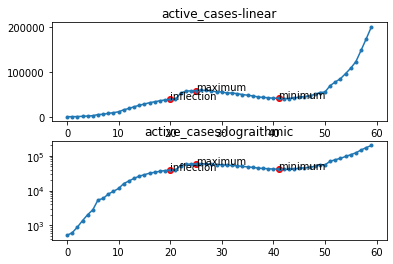

In [44]:
worldwide = df[df['Country/Region']=='worldwide']
ShowData(worldwide,'active_cases','smooth_active_first_derivative','smooth_active_second_derivative',10,1000,tit='')

C:\Users\Arik\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Arik\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


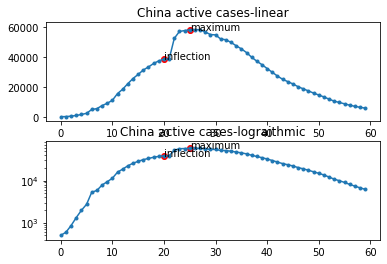

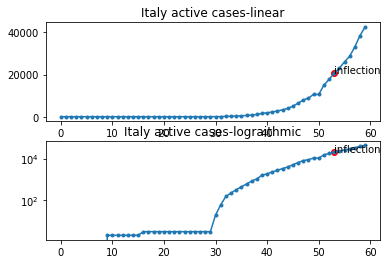

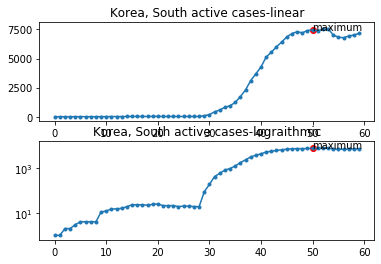

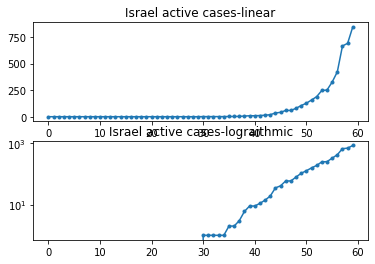

In [41]:
#countries
CList = ['China','Italy','Korea, South','Israel']
keyList = df.keys()
keyList = keyList[2:]
#df[['active_cases','confirmed_cases','dead_cases','recovered_cases']].groupby('Country/Region')
for c in CList:
    temp_df = df[df['Country/Region']==c]
    country_df = temp_df.iloc[[0]]
    country_df['Province/State']='all'
    #country_df = country_df.groupby(['Country/Region'],as_index=False)
    #print(country_df.head())
    for k in keyList:
        tot = pd.DataFrame(temp_df[k].tolist()).sum(0)
        country_df[k] = [tot.values.tolist()]
    #df.loc[-1] = ['worldwide','worldwide',tot.values]
    #
    ShowData(country_df,'active_cases','smooth_active_first_derivative','smooth_active_second_derivative',10,500,tit=c+' active cases')

In [46]:
print(df.keys())

Index(['Province/State', 'Country/Region', 'confirmed_cases',
       'confirmed_first_derivative', 'confirmed_second_derivative',
       'dead_cases', 'dead_first_derivative', 'dead_second_derivative',
       'recovered_cases', 'recovered_first_derivative',
       'recovered_second_derivative', 'active_cases',
       'active_first_derivative', 'active_second_derivative', 'smooth_active',
       'smooth_active_first_derivative', 'smooth_active_second_derivative'],
      dtype='object')


In [35]:
print(df[df['Country/Region'].str.contains("Korea")])

    Province/State Country/Region  \
156            NaN   Korea, South   

                                       confirmed_cases  \
156  [1, 1, 2, 2, 3, 4, 4, 4, 4, 11, 12, 15, 15, 16...   

                            confirmed_first_derivative  \
156  [0.5, 0.5, 0.5, 1.0, 0.5, 0.0, 0.0, 3.5, 4.0, ...   

                           confirmed_second_derivative  \
156  [1, -1, 1, 0, -1, 0, 0, 7, -6, 2, -3, 1, 2, 1,...   

                                            dead_cases  \
156  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                 dead_first_derivative  \
156  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                dead_second_derivative  \
156  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                       recovered_cases  \
156  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                            recovered_first_derivative  \
156  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.